In [18]:
import torch
import random
import torchvision.transforms.functional as FT
from torch.utils.data import Dataset
from PIL import Image
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

In [11]:
path_imgs ="/data/ssd_ilija_data/original_images/*"
path_bboxes_labels = "/data/ssd_ilija_data/ground_truth/bboxes_labels/"
imgs = glob.glob(path_imgs)
bboxes = glob.glob(path_bboxes_labels+"bboxes*")
labels = glob.glob(path_bboxes_labels+"labels*")

In [14]:
imgs.sort()
bboxes.sort()
labels.sort()

In [78]:
def intersection(box_a, box_b):
    """ Compute intersection between each two boxes in the sets box_a and box_b
    Args:
      :box_a  bounding boxes, Shape: (N,4).
      :box_b  bounding boxes, Shape: (M,4).
    Return:
      Intersection area, Shape: (N,M).
    """

    max_xy = torch.min(box_a[:, 2:].unsqueeze(1), box_b[:, 2:].unsqueeze(0))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1), box_b[:, :2].unsqueeze(0))
    inter = torch.clamp((max_xy - min_xy), min=0)

    return inter[:, :, 0] * inter[:, :, 1]

def jaccard_overlap(set_a, set_b):

    """Compute Jaccard Overlap between 2 boxes, which is: a ∩ B / a ∪ b
        :set_a set of bounding boxes Shape: (N, format of encoding)
        :set_b: set of bounding boxes Shape: (M, format of encoding)
        Format of encoding must be the same for both sets
    Return:
        a ∩ B / a ∪ b

    """
    intersection_seta_setb = intersection(set_a, set_b)

    area_set_a = ((set_a[:, 2] - set_a[:, 0]) * (set_a[:, 3] - set_a[:, 1])).unsqueeze(1)
    area_set_b = ((set_b[:, 2] - set_b[:, 0]) * (set_b[:, 3] - set_b[:, 1])).unsqueeze(0)

    union_seta_setb = area_set_a + area_set_b - intersection_seta_setb

    return intersection_seta_setb/union_seta_setb

def random_crop(image, boxes, labels):
    """
    Performs a random crop operation with multiple possibilities as in the paper.
    Helpful when detecting bigger objects(windows, doors, buildings). 
    Ref: https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    """
    height, width = image.size(1), image.size(2)

    while True:
        #randomly choose a min overlap
        mode = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # Do not crop if NONE
        if mode is None:
            return image, boxes, labels

        # Do 50 trials
        max_trials = 50
        for _ in range(max_trials):
            
            # Crop dimensions must be in [0.3, 1] of original dimensions
            new_height = int(random.uniform(0.3, 1) * height)
            new_width = int(random.uniform(0.3, 1) * width)

            # Aspect ratio must be in [0.5, 2]
            aspect_ratio = new_height / new_width
            if not 0.5 < aspect_ratio < 2:
                continue

            # Get crop coordinates
            left = random.randint(0, width - new_width)
            right = left + new_width
            top = random.randint(0, height - new_height)
            bottom = top + new_height
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Compute jaccard overlap between crop and bboxes
            overlap = jaccard_overlap(crop.unsqueeze(0),
                                           boxes)
            
            overlap = overlap.squeeze(0)  

            # If all overlaps are smaller try again 
            if overlap.max().item() < mode:
                continue

            #Crop the image
            new_image = image[:, top:bottom, left:right]
            
            #Get centers of bounding boxxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (bb_centers[:, 1] < bottom)  

            #If no boxes are in the crop try again
            if not centers_in_crop.any():
                continue

            #Remove bounding boxes that do not satisfy cond
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]

            # Compute the positions of bounding boxes in the new img
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:]) 
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels
def expand(img, bboxes, mean):
    """
    Performs a zoom out operation with 50% possibility as in the paper.
    Helpful when detecting smaller objects(windows, doors). 
    Ref: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py
    """
    #Convert img to tensor, and redefine mean to fill out surrounding space of the data that our base was trained on. 
    img = FT.to_tensor(img)
    filler = torch.FloatTensor(mean).unsqueeze(1).unsqueeze(1)
    if random.random() > 0.5:
        return img, bboxes
  
    
    height, width = img.size(1), img.size(2)
    #Ratio of expansion
    ratio = random.uniform(1, 4)
    #Expand
    new_img = torch.ones((3, int(ratio * height), int(ratio * width)), dtype=torch.float) * filler

    #place original image 
    left = random.randint(0, int(ratio * width) - width)
    top = random.randint(0, int(ratio * height) - height)
    new_img[:, top:(top+height), left:(left+width)] = img

    #expand bounding boxes respectively
    new_bboxes = bboxes + torch.FloatTensor([left, top, left, top]).unsqueeze(0)  

    return new_img, new_bboxes

def random_hflip(img, boxes):
    """
    Horizontal flip of img and bounding boxes with a 50% possibility
    """
    img = FT.to_pil_image(img)
    if random.random() > 0.5:
        return img, boxes
    #Flip Image
    img = FT.hflip(img)
    img_w = img.width

    # Flip bounding boxes
    new_boxes = boxes
    new_boxes[:, 0] = img_w - boxes[:, 0] - 1
    new_boxes[:, 2] = img_w - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return img, new_boxes
def photometric_distort(img):
    #REF: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
    #Apply distortions on brightness, contrast, saturation, hue
    new_img = img

    distortions = [FT.adjust_brightness,
                   FT.adjust_contrast,
                   FT.adjust_saturation,
                   FT.adjust_hue]

    random.shuffle(distortions)

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is 'adjust_hue':
                #Empirical Values taken out of Original/Caffe Repo
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:
                #Empirical Values taken out of Original/Caffe Repo
                adjust_factor = random.uniform(0.5, 1.5)

            # Apply each distortion
            new_img = d(new_img, adjust_factor)

    return new_img

In [36]:
img = Image.open(imgs[10])
boxes = np.load(bboxes[10])

In [39]:
b_boxes = torch.FloatTensor(boxes[:, :4])
labels = torch.FloatTensor(boxes[:, 4:])

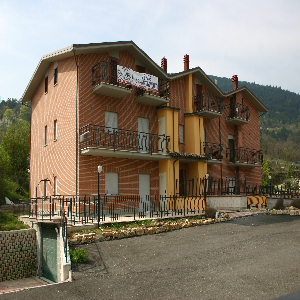

In [95]:
img

In [106]:
photo_img = photometric_distort(img)

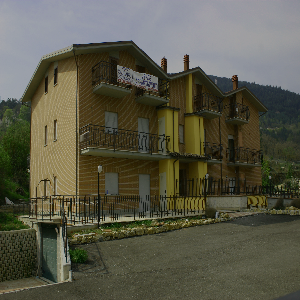

In [107]:
iphoto_img

In [109]:
expand_img, expand_b_boxes = expand(photo_img, b_boxes, [0.485, 0.456, 0.406])

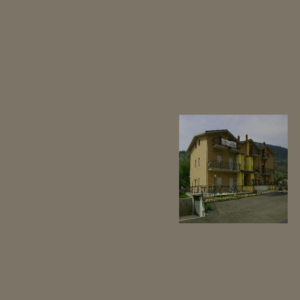

In [115]:
FT.resize(FT.to_pil_image(expand_img), size = 300)

In [117]:
crop_img, crop_b_boxes, crop_labels = random_crop(expand_img, expand_b_boxes, labels)

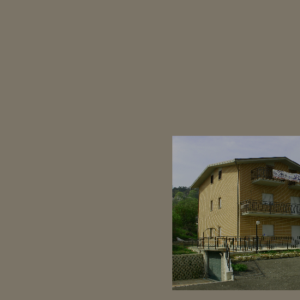

In [122]:
FT.resize(FT.to_pil_image(crop_img), size = (300, 300))

In [123]:
hflip_img, hflip_b_boxes = random_hflip(crop_img, crop_b_boxes)

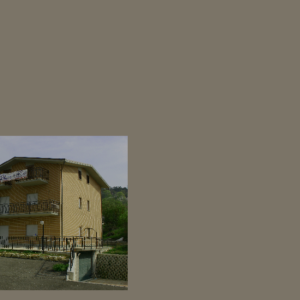

In [125]:
FT.resize(hflip_img, size = (300, 300))